The purpose of this notebook is to show a sample of ML capabilities in Viya VDMML using the jupyter interface. **We create a ML pipeline to train and compare models in Python and SAS, for an example supervised learning problem : loan default prediction.**

In this Jupyer notebook, we will - 

1. First read data into a into a Pandas data frame on the client laptop
2. Then uploaded to the CAS server(s) - for distributed in-memory processing
3. We'll then do some simple Data Manipulation steps
4. Build Logistic Regression model (CAS & Python)
5. Compare the Parameter Estimates generated by both techniques

In [1]:
# Import necessary packages and modules
import swat
import pandas as pd
import collections
from matplotlib import pyplot as plt
swat.options.cas.print_messages = True
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
indata     = 'hmeq' #name of the data set

In [3]:
# Host, port, username, password
s = swat.CAS('10.96.3.242', 5570, 'sasdemo', 'Orion123')

In [4]:
s.serverstatus()

NOTE: Grid node action status report: 1 nodes, 8 total actions executed.


[About]

 {'CAS': 'Cloud Analytic Services',
  'Version': '3.05',
  'VersionLong': 'V.03.05M0P11062019',
  'Copyright': 'Copyright © 2014-2018 SAS Institute Inc. All Rights Reserved.',
  'ServerTime': '2020-05-23T07:13:31Z',
  'System': {'Hostname': 'sasserver.demo.sas.com',
   'OS Name': 'Linux',
   'OS Family': 'LIN X64',
   'OS Release': '3.10.0-957.27.2.el7.x86_64',
   'OS Version': '#1 SMP Mon Jul 29 17:46:05 UTC 2019',
   'Model Number': 'x86_64',
   'Linux Distribution': 'CentOS Linux release 7.6.1810 (Core)'},
  'license': {'site': 'DEMOCENTER - Prod 19w47 19Nov2019 : Kitchen v5',
   'siteNum': 70180938,
   'expires': '02Dec2020:00:00:00',
   'gracePeriod': 45,
   'warningPeriod': 45,
   'maxCPUs': 9999}}

[server]

 Server Status
 
    nodes  actions
 0      1        8

[nodestatus]

 Node Status
 
                      name        role  uptime  running  stalled
 0  sasserver.demo.sas.com  controller   3.599        0        0

+ Elapsed: 0.000928s, user: 0.000865s, mem: 0.301mb

In [5]:
# Load actionsets for analysis (for data prep, modeling, assessing)
actionsets = ['cardinality', 'sampling', 'fedSQL', 'decisionTree','astore','regression']
[s.builtins.loadactionset(i) for i in actionsets]

NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'fedSQL'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'astore'.
NOTE: Added action set 'regression'.


[[actionset]
 
  'cardinality'
 
 + Elapsed: 0.0056s, user: 5.8e-05s, sys: 0.00102s, mem: 0.204mb, [actionset]
 
  'sampling'
 
 + Elapsed: 0.00264s, user: 0.000755s, sys: 0.00183s, mem: 0.209mb, [actionset]
 
  'fedSQL'
 
 + Elapsed: 0.00203s, user: 0.000995s, sys: 0.000984s, mem: 0.239mb, [actionset]
 
  'decisionTree'
 
 + Elapsed: 0.00211s, user: 0.000242s, sys: 0.00182s, mem: 0.22mb, [actionset]
 
  'astore'
 
 + Elapsed: 0.0013s, user: 0.00124s, mem: 0.22mb, [actionset]
 
  'regression'
 
 + Elapsed: 0.00363s, user: 0.00175s, sys: 0.00183s, mem: 0.208mb]

In [6]:
df = pd.read_csv('/home/sasdemo/hmeq.csv')

In [7]:
df.dtypes

BAD          int64
LOAN         int64
MORTDUE    float64
VALUE      float64
REASON      object
JOB         object
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object

In [8]:
df['BAD'] = df['BAD'].astype(str)

In [9]:
df.dtypes

BAD         object
LOAN         int64
MORTDUE    float64
VALUE      float64
REASON      object
JOB         object
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object

In [10]:
s.upload(df,casout='HMEQ')

NOTE: Cloud Analytic Services made the uploaded file available as table HMEQ in caslib CASUSER(sasdemo).
NOTE: The table HMEQ has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.


[caslib]

 'CASUSER(sasdemo)'

[tableName]

 'HMEQ'

[casTable]

 CASTable('HMEQ', caslib='CASUSER(sasdemo)')

+ Elapsed: 0.0155s, user: 0.0198s, sys: 0.00867s, mem: 27mb

In [11]:
s.tableinfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,HMEQ,5960,13,0,utf-8,2020-05-23T03:15:04-04:00,2020-05-23T03:15:04-04:00,2020-05-23T03:15:04-04:00,UTF8,1.905837e+09,...,0,0,0,,,0,sasdemo,,2020-05-23T03:15:04-04:00,1.905837e+09


In [12]:
castbl = s.CASTable('HMEQ',replace=True)

In [13]:
castbl.dtypes #BAD is the target variable we wish to predict

BAD        varchar
LOAN        double
MORTDUE     double
VALUE       double
REASON     varchar
JOB        varchar
YOJ         double
DEROG       double
DELINQ      double
CLAGE       double
NINQ        double
CLNO        double
DEBTINC     double
dtype: object

In [14]:
# Create table of summary statistics in SAS
castbl.cardinality.summarize(cardinality = dict(name = 'data_card', replace = True))
df_data_card = s.CASTable('data_card').to_frame() # bring the data locally

# Modify SAS output table using Python to present summary statistics
df_data_card['_PCTMISS_'] = (df_data_card['_NMISS_']/df_data_card['_NOBS_'])*100
print('\n', 'Summary Statistics'.center(90, ' '))
df_data_card[['_VARNAME_','_TYPE_','_PCTMISS_','_MIN_','_MAX_','_MEAN_','_STDDEV_','_SKEWNESS_','_KURTOSIS_']].round(2)

NOTE: Writing cardinality.
NOTE: status = 0.
NOTE: The Cloud Analytic Services server processed the request in 0.022787 seconds.

                                     Summary Statistics                                    


,_VARNAME_,_TYPE_,_PCTMISS_,_MIN_,_MAX_,_MEAN_,_STDDEV_,_SKEWNESS_,_KURTOSIS_
0,BAD,C,0.00,NaN,NaN,NaN,NaN,NaN,NaN
1,LOAN,N,0.00,1100.00,89900.00,18607.97,11207.48,2.02,6.93
2,MORTDUE,N,8.69,2063.00,399550.00,73760.82,44457.61,1.81,6.48
3,VALUE,N,1.88,8000.00,855909.00,101776.05,57385.78,3.05,24.36
4,REASON,C,4.23,NaN,NaN,NaN,NaN,NaN,NaN
5,JOB,C,4.68,NaN,NaN,NaN,NaN,NaN,NaN
6,YOJ,N,8.64,0.00,41.00,8.92,7.57,0.99,0.37
7,DEROG,N,11.88,0.00,10.00,0.25,0.85,5.32,36.87
8,DELINQ,N,9.73,0.00,15.00,0.45,1.13,4.02,23.57
9,CLAGE,N,5.17,0.00,1168.23,179.77,85.81,1.34,7.60


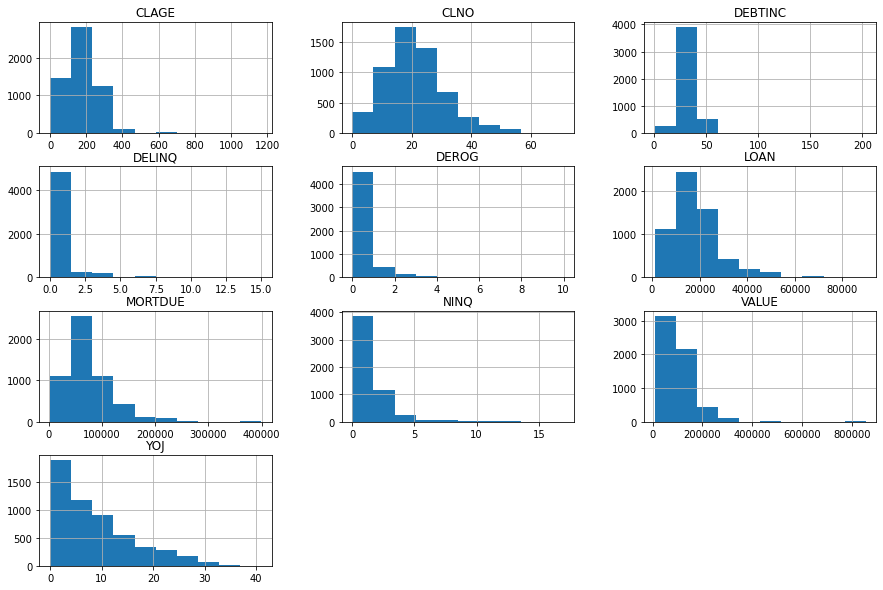

In [15]:
# Use the built in hist() method to plot the distribution of every variable
castbl.hist(figsize = (15, 10));

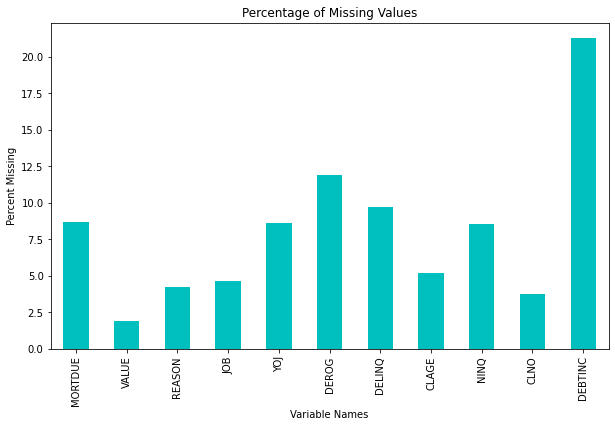

In [16]:
# Plot missing values in matplotlib
df_data_miss = df_data_card[df_data_card['_PCTMISS_'] > 0]
tbl_forplot  = pd.Series(list(df_data_miss['_PCTMISS_']), index = list(df_data_miss['_VARNAME_']))
missing_val  = tbl_forplot.plot(kind  = 'bar', title = 'Percentage of Missing Values', color = 'c', figsize = (10, 6))
missing_val.set_ylabel('Percent Missing')
missing_val.set_xlabel('Variable Names');

#### I perform the imputation and splitting into train / test in SAS and use the same data in Python later for model build so that I minimize the variability for a fair comparison

In [17]:
# Impute missing values
castbl.dataPreprocess.impute(
    outVarsNamePrefix = 'IMP',
    methodContinuous  = 'MEDIAN',
    methodNominal     = 'MODE',
    inputs            = list(df_data_card['_VARNAME_'])[1:],
    copyAllVars       = True,
    casOut            = castbl,
)

# Print the first five rows with imputations
castbl.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,...,IMP_DEBTINC,IMP_DELINQ,IMP_DEROG,IMP_LOAN,IMP_MORTDUE,IMP_NINQ,IMP_VALUE,IMP_YOJ,IMP_JOB,IMP_REASON
0,1,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,...,34.818262,0.0,0.0,1100.0,25860.0,1.0,39025.0,10.5,Other,HomeImp
1,1,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,...,34.818262,2.0,0.0,1300.0,70053.0,0.0,68400.0,7.0,Other,HomeImp
2,1,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,...,34.818262,0.0,0.0,1500.0,13500.0,1.0,16700.0,4.0,Other,HomeImp
3,1,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,...,34.818262,0.0,0.0,1500.0,65019.0,1.0,89235.5,7.0,Other,DebtCon
4,0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,...,34.818262,0.0,0.0,1700.0,97800.0,0.0,112000.0,3.0,Office,HomeImp


In [18]:
# Create a 70/30 simple random sample split
castbl.sampling.srs(
    samppct = 70,
    partind = True,
    seed    = 1,
    output  = dict(casOut = castbl, copyVars = 'ALL')
)

NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=1 for sampling.


[SRSFreq]

 Frequencies
 
    NObs  NSamp
 0  5960   4172

[OutputCasTables]

              casLib  Name Label  Rows  Columns  \
 0  CASUSER(sasdemo)  HMEQ        5960       26   
 
                                       casTable  
 0  CASTable('HMEQ', caslib='CASUSER(sasdemo)')  

+ Elapsed: 0.0156s, user: 0.0137s, sys: 0.0106s, mem: 30.7mb

#### Here we can execute FedSQL statements on an in-memory table in real-time


In [19]:
# Verify the partition worked properly using SQL
s.fedSQL.execDirect('''
    SELECT 
        CASE WHEN _PartInd_ = 1 THEN 'Training' ELSE 'Validation' END AS Name,
        _PartInd_,
        100.0*COUNT(*)/(SELECT COUNT(*) FROM ''' + indata + ''') AS Pct
    FROM ''' + indata + '''
    GROUP BY
        CASE WHEN _PartInd_ = 1 THEN 'Training' ELSE 'Validation' END,
        _PartInd_
    ORDER BY _PartInd_ DESC;
''')

,NAME,_PartInd_,PCT
0,Training,1.0,70.0
1,Validation,0.0,30.0


#### Generate lists of Class and Interval variables to be used as input to the model


In [20]:
# Set variables for later use by models
## For models that can handle missing values
target              = df_data_card['_VARNAME_'][0]
class_inputs        = list(df_data_card.query('_TYPE_ == "C"')['_VARNAME_'])[1:]
interval_inputs     = list(df_data_card.query('_TYPE_ == "N"')['_VARNAME_'])[0:]
class_vars          = [target] + class_inputs
all_inputs          = interval_inputs + class_inputs

## For models that can't handle missing values
imp_class_inputs    = ['IMP_' + s for s in class_inputs]
imp_interval_inputs = ['IMP_' + s for s in interval_inputs]
imp_class_vars      = [target] + imp_class_inputs
imp_all_inputs      = imp_interval_inputs + imp_class_inputs

In [21]:
target

'BAD'

In [22]:
class_inputs

['REASON', 'JOB']

In [23]:
interval_inputs

['LOAN',
 'MORTDUE',
 'VALUE',
 'YOJ',
 'DEROG',
 'DELINQ',
 'CLAGE',
 'NINQ',
 'CLNO',
 'DEBTINC']

In [24]:
imp_class_vars

['BAD', 'IMP_REASON', 'IMP_JOB']

In [25]:
imp_all_inputs

['IMP_LOAN',
 'IMP_MORTDUE',
 'IMP_VALUE',
 'IMP_YOJ',
 'IMP_DEROG',
 'IMP_DELINQ',
 'IMP_CLAGE',
 'IMP_NINQ',
 'IMP_CLNO',
 'IMP_DEBTINC',
 'IMP_REASON',
 'IMP_JOB']

**Run Logsitic Regression in SAS using below hyperparameters**

The numerical optimization techniques supported in SAS are -

* Trust Region Optimization (TRUREG)
* Newton-Raphson Optimization with Line Search
* Newton-Raphson Ridge Optimization
* Quasi-Newton Optimization
* Double-Dogleg Optimization
* Conjugate Gradient Optimization
* Levenberg-Marquardt Optimization
* Nelder-Mead Simplex Optimization

We will choose the CG method for a fair comparsion.

In [26]:
log_reg = castbl.logistic(class_=[dict(vars=imp_class_vars)],
                                   model={"depvars":[{"name":"BAD", "options":{"event":"1"}}],
                                        "effects":[dict(vars=imp_all_inputs)]
                                         },
                                   partbyvar={"name": "_partind_", "train": "1", "valid": "0"},
                                   optimization=dict(technique="CONGRA",maxIter=100),
                                   output=dict(casout=dict(name="scored_logistic_data",
                                                          replace=True),
                                              copyvars="ALL")
                                  )

NOTE: Convergence criterion (FCONV=1E-7) satisfied.
NOTE: At least one element of the gradient is greater than 1e-3.


In [27]:
from swat.render import render_html

#### This handy function gives you the detailed stack trace print of all statistical steps. Note - Look at Parameter estimates and Misclassification Rates

In [28]:
render_html(log_reg)

Model Information 
 RowId 
 Description 
 Value 
 
 
 DATA Data Source HMEQ 
 RESPONSEVAR Response Variable BAD 
 DIST Distribution Binary 
 LINK Link Function Logit 
 TECH Optimization Technique Conjugate Gradient 
 
 
 
 
 Number of Observations 
 RowId 
 Description 
 Total 
 Training 
 Validation 
 
 
 NREAD Number of Observations Read 5960 4172 1788 
 NUSED Number of Observations Used 5960 4172 1788 
 
 
 
 
 Response Profile 
 Ordered Value 
 BAD 
 BAD 
 Total Frequency 
 Training 
 Validation 
 Probability Modeled 
 
 
 1 0 0 4771 3335 1436 
 2 1 1 1189 837 352 * 
 
 
 
 
 Class Level Information 
 Class 
 Levels 
 Values 
 
 
 IMP_REASON 2 DebtCon HomeImp 
 IMP_JOB 6 Mgr Office Other ProfExe Sales Self 
 
 
 
 
 Convergence Status 
 Reason 
 Status 
 Max Gradient 
 2:complete 1:quasi 0:okay -1:maybe quasi -2:undetermined -3:not checked 
 
 
 Convergence criterion (FCONV=1E-7) satisfied. 0 3.7053810724 -3 
 
 
 
 
 Dimensions 
 RowId 
 Description 
 Value 
 
 
 NDESIGNCOLS Columns in Design 19 
 NEFFECTS Number of Effects 13 
 MAXEFCOLS Max Effect Columns 6 
 DESIGNRANK Rank of Design 17 
 OPTPARM Parameters in Optimization 17 
 
 
 
 
 Likelihood Ratio Test 
 Test 
 DF 
 Chi-Square 
 Pr > ChiSq 
 
 
 Likelihood Ratio 16 969.89766122 3.11273E-196 
 
 
 
 
 Fit Statistics 
 RowId 
 Description 
 Training 
 Validation 
 
 
 M2LL -2 Log Likelihood 3212.6587723 1455.3169359 
 AIC AIC (smaller is better) 3246.6587723 1489.3169359 
 AICC AICC (smaller is better) 3246.8061002 1489.6626986 
 SBC SBC (smaller is better) 3354.3733362 1582.6274361 
 ASE Average Square Error 0.1187763535 0.1268059603 
 M2LLNULL -2 Log L (Intercept-only) 4182.5564335 1773.8025172 
 RSQUARE R-Square 0.207432709 0.1631612898 
 ADJRSQ Max-rescaled R-Square 0.3276718013 0.2593204874 
 MCFADDEN McFadden's R-Square 0.2318911117 0.1795496276 
 MISCLASS Misclassification Rate 0.1637104506 0.1705816555 
 DIFFMEAN Difference of Means 0.230562817 0.2045270923 
 
 
 
 
 Parameter Estimates 
 Effect 
 IMP_REASON 
 IMP_JOB 
 Parameter 
 Parameter 
 DF 
 Estimate 
 Standard Error 
 Chi-Square 
 Pr > ChiSq 
 
 
 Intercept Intercept Intercept 1 -1.540389583 0.3485506838 19.531215309 9.8969144E-6 
 IMP_LOAN IMP_LOAN IMP_LOAN 1 -0.000018444 4.7810499E-6 14.8826572 0.00011441 
 IMP_MORTDUE IMP_MORTDUE IMP_MORTDUE 1 -2.880442E-6 1.6145377E-6 3.1828911241 0.074412958 
 IMP_VALUE IMP_VALUE IMP_VALUE 1 3.598923E-6 1.1628731E-6 9.5781236879 0.0019690954 
 IMP_YOJ IMP_YOJ IMP_YOJ 1 -0.002116585 0.0065179988 0.1054490614 0.7453860235 
 IMP_DEROG IMP_DEROG IMP_DEROG 1 0.5803096375 0.0571789913 103.00222042 3.347728E-24 
 IMP_DELINQ IMP_DELINQ IMP_DELINQ 1 0.652044299 0.0428545496 231.504978 2.799861E-52 
 IMP_CLAGE IMP_CLAGE IMP_CLAGE 1 -0.003268119 0.0006158228 28.163346342 1.1149617E-7 
 IMP_NINQ IMP_NINQ IMP_NINQ 1 0.1654927019 0.023999033 47.552155603 5.355983E-12 
 IMP_CLNO IMP_CLNO IMP_CLNO 1 -0.011722795 0.0048758363 5.7804831092 0.0162050867 
 IMP_DEBTINC IMP_DEBTINC IMP_DEBTINC 1 0.034745899 0.006701693 26.880543578 2.1642673E-7 
 IMP_REASON DebtCon IMP_REASON DebtCon IMP_REASON_DebtCon 1 -0.259546423 0.0975294555 7.0820419883 0.0077860235 
 IMP_REASON HomeImp IMP_REASON HomeImp IMP_REASON_HomeImp 0 0 nan nan nan 
 IMP_JOB Mgr IMP_JOB Mgr IMP_JOB_Mgr 1 -0.584703106 0.2469411621 5.6063967331 0.0178950242 
 IMP_JOB Office IMP_JOB Office IMP_JOB_Office 1 -0.95757441 0.2479791695 14.911270921 0.0001126877 
 IMP_JOB Other IMP_JOB Other IMP_JOB_Other 1 -0.583779208 0.2275729493 6.5804557152 0.0103104492 
 IMP_JOB ProfExe IMP_JOB ProfExe IMP_JOB_ProfExe 1 -0.702411593 0.2372404346 8.7660898923 0.0030688264 
 IMP_JOB Sales IMP_JOB Sales IMP_JOB_Sales 1 0.4876267338 0.3587459835 1.8475700787 0.1740662733 
 IMP_JOB Self IMP_JOB Self IMP_JOB_Self 0 0 nan nan nan 
 
 
 
 
 Task Timing 
 RowId 
 Task 
 Time 
 Relative Time 
 
 
 SETUP Setup and Parsing 0.0049960613 0.0892693587 
 LEVELIZATION Levelization 0.0036540031 0.0652895343 
 INITIALIZATION Model Initialization 0.0006220341

**We get validation misclassification rate = 0.1705816555 (using Conjugate Gradient as the optimization function)**

**We get validation misclassification rate = 0.1661073826 (using Newton-Raphson with Ridging as the optimization function)**

#### Extract the parameter estimates into a dataframe for comparison later


In [29]:
df_sas = pd.DataFrame(log_reg['ParameterEstimates'])

In [30]:
df_sas = df_sas[['Parameter','Estimate']]

In [31]:
df_sas

,Parameter,Estimate
0,Intercept,-1.540390
1,IMP_LOAN,-0.000018
2,IMP_MORTDUE,-0.000003
3,IMP_VALUE,0.000004
4,IMP_YOJ,-0.002117
5,IMP_DEROG,0.580310
6,IMP_DELINQ,0.652044
7,IMP_CLAGE,-0.003268
8,IMP_NINQ,0.165493
9,IMP_CLNO,-0.011723


#### Build the Logistic Regression model in scikit-learn using the same hyperparameters

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

#### Making sure the same training / validation data is used in both SAS and Python models for fair comparison


In [33]:
# Bring specified columns to the client (note: Python models must be run locally)
local_inputs = [target, '_PartInd_'] + imp_all_inputs
local = castbl[local_inputs].to_frame()

# Create dummy variables for class inputs (note: scikit-learn cannot have character variables)
local = pd.concat([local, pd.get_dummies(local[imp_class_inputs])], axis = 1).drop(imp_class_inputs, axis = 1)

# Split into training and validation
train = local[local['_PartInd_'] == 1]
valid = local[local['_PartInd_'] == 0]

# Split target and inputs and remove unnecessary variables
X_train = train.drop([target,'_PartInd_'], axis = 1)
X_valid = valid.drop([target,'_PartInd_'], axis = 1)
y_train = train[target]
y_valid = valid[target]

In [34]:
len(X_train.columns)


18

**Change the default parameters as below**

* We are using the following optimization paramters available in scikit-learn library

    * 'newton-cg' method = Newton Conjugate Gradient method (not much information is provided on how this method is implemented)
    * Max iterations for convergence = 100
    * No regularization, hence penalty = 'none'

In [35]:
model = LogisticRegression(solver='newton-cg',max_iter=100,penalty='none')
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
df = pd.DataFrame(dict(actual = y_valid, pred = model.predict_proba(X_valid)[:,1])) # put results in pandas dataframe

# Predict and assess model
lr_y_score           = model.predict(X_valid)
lr_misclassification = 1 - accuracy_score(y_valid, lr_y_score)
lr_confusion_matrix  = confusion_matrix(y_valid, lr_y_score)

print('Confusion Matrix\n', lr_confusion_matrix, '\n') # note: scikit-learn reverses True Positives and True Negatives
print('Misclassification Rate\n ', lr_misclassification)

Confusion Matrix
 [[1378   58]
 [ 243  109]] 

Misclassification Rate
  0.16834451901565994


* We get validation misclassification rate = 0.16834451901565994

* However, using other methods available in scikit-learn, like 'lbfgs', 'sag', we get even worse accuracy.

In [37]:
model.coef_

array([[-2.42052985e-05, -3.96439851e-06,  3.77536786e-06,
        -3.44862948e-03,  6.51532050e-01,  7.84778032e-01,
        -5.83093893e-03,  1.86948845e-01, -1.48305247e-02,
         5.59994442e-02, -8.28887941e-01, -5.01447930e-01,
        -3.79406951e-01, -9.96121695e-01, -3.97950991e-01,
        -5.46853135e-01,  5.82864173e-01,  4.07132728e-01]])

In [38]:
X_train.index

Int64Index([   2,    4,    7,   10,   11,   15,   17,   18,   20,   22,
            ...
            5944, 5947, 5948, 5950, 5951, 5953, 5954, 5956, 5957, 5959],
           dtype='int64', length=4172)

In [39]:
X_valid.index

Int64Index([   0,    1,    3,    5,    6,    8,    9,   12,   13,   14,
            ...
            5932, 5936, 5938, 5941, 5945, 5946, 5949, 5952, 5955, 5958],
           dtype='int64', length=1788)

In [40]:
model.predict_proba(X_valid)

array([[0.68884512, 0.31115488],
       [0.42641224, 0.57358776],
       [0.84681286, 0.15318714],
       ...,
       [0.96126266, 0.03873734],
       [0.98204726, 0.01795274],
       [0.98429218, 0.01570782]])

#### Store all values in a single dataframe for side-by-side comparison


In [41]:
import numpy as np
coefficients = {}

In [42]:
coefficients = pd.concat([pd.DataFrame(X_train.columns,columns=['Parameter_Python']),pd.DataFrame(np.transpose(model.coef_),columns=['Value_Python'])], axis = 1)
coefficients

,Parameter_Python,Value_Python
0,IMP_LOAN,-0.000024
1,IMP_MORTDUE,-0.000004
2,IMP_VALUE,0.000004
3,IMP_YOJ,-0.003449
4,IMP_DEROG,0.651532
5,IMP_DELINQ,0.784778
6,IMP_CLAGE,-0.005831
7,IMP_NINQ,0.186949
8,IMP_CLNO,-0.014831
9,IMP_DEBTINC,0.055999


In [43]:
line_append = pd.DataFrame({"Parameter_Python": "Intercept", "Value_Python": float(model.intercept_)}, index=[0])

In [44]:
line_append

,Parameter_Python,Value_Python
0,Intercept,-1.330336


In [45]:
coefficients = coefficients.append(line_append, ignore_index=False)
coefficients = coefficients.sort_index().reset_index(drop=True)
coefficients

,Parameter_Python,Value_Python
0,IMP_LOAN,-0.000024
1,Intercept,-1.330336
2,IMP_MORTDUE,-0.000004
3,IMP_VALUE,0.000004
4,IMP_YOJ,-0.003449
5,IMP_DEROG,0.651532
6,IMP_DELINQ,0.784778
7,IMP_CLAGE,-0.005831
8,IMP_NINQ,0.186949
9,IMP_CLNO,-0.014831


In [46]:
coefficients_sas_python = pd.concat([coefficients,df_sas],axis = 1)

**Compare the coefficients side by side**

* The results may be different because SAS creates (n-1) dummies for categorical variables to avoid multi-collinearity while pandas creates (n) dummies for the same. (n-1) avoids the dummy variable trap

* However, one can see that the general information capture by the coefficients (direction wise) is largely the same. We can achieve better performace using better optimization techniques. (Newton Raphson method with ridging in SAS gives better accuracy)

* We cannot control the 'seed' (give the solver its initial guess as the coefficients' values) value for the optimization technique used even though it's the same in both cases

* The Logistic regression procedure in SAS is specifically designed to operate in SAS Viya and performs computations in multiple threads as opposed to single threaded scikit-learn function. This can also be the reason for different outputs

* The way data is processed in single threaded and multi-threaded way can give different results

In [47]:
coefficients_sas_python

,Parameter_Python,Value_Python,Parameter,Estimate
0,IMP_LOAN,-0.000024,Intercept,-1.540390
1,Intercept,-1.330336,IMP_LOAN,-0.000018
2,IMP_MORTDUE,-0.000004,IMP_MORTDUE,-0.000003
3,IMP_VALUE,0.000004,IMP_VALUE,0.000004
4,IMP_YOJ,-0.003449,IMP_YOJ,-0.002117
5,IMP_DEROG,0.651532,IMP_DEROG,0.580310
6,IMP_DELINQ,0.784778,IMP_DELINQ,0.652044
7,IMP_CLAGE,-0.005831,IMP_CLAGE,-0.003268
8,IMP_NINQ,0.186949,IMP_NINQ,0.165493
9,IMP_CLNO,-0.014831,IMP_CLNO,-0.011723


### Detailed description of Logsitic Regression in SAS
https://go.documentation.sas.com/?docsetId=casstat&docsetVersion=8.3&docsetTarget=casstat_logselect_overview01.htm&locale=en

### Optimization Techniques description in SAS
https://go.documentation.sas.com/?docsetId=casstat&docsetTarget=casstat_introcom_sect065.htm&docsetVersion=8.3&locale=en